# Arecibo Planetary Radar Doppler/Delay Image Processing

References:
* https://iopscience.iop.org/article/10.3847/PSJ/ac4f43/pdf -- *Arecibo Radar Maps of Venus from 1988 to 2020* (overview paper)
* https://pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/document/venus_radar.pdf -- Level 1 doppler/dely data description
* https://pds-geosciences.wustl.edu/venus/urn-nasa-pds-venus_radar_level2/document/venus_radar_maps_user_guide.pdf -- Level 2 multi-look data description
* https://repository.si.edu/bitstream/handle/10088/3303/200737.pdf -- *Focused 70-cm wavelength radar mapping of the moon* Details on the doppler-delay transformations
* https://echo.jpl.nasa.gov/asteroids/harmon.2002.long.code.pdf -- Details on the long-code doppler-delay method
* https://articles.adsabs.harvard.edu/pdf/1974Moon...10....3P -- Pettingill et al, original introduction of the doppler-delay method

Related:
* https://arxiv.org/abs/2103.01504 -- Spin state and moment of inertia of Venus -- latest estimates for rotational parameters using radar speckle method
* https://pubs.usgs.gov/of/1993/0516/report.pdf -- Venus Geologic Mappers' Handbook

Tools/Libraries:
* https://ssd.jpl.nasa.gov/horizons/app.html#/ -- JPL Horizons web app
* https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html -- JPL Horizons Python API
* https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf -- Latest ephemerides description
* https://astropedia.astrogeology.usgs.gov/download/Docs/WGCCRE/WGCCRE2009reprint.pdf --  Report of the IAU Working Group on Cartographic Coordinates and Rotational Elements: 2009
* https://escholarship.org/content/qt2dn1012s/qt2dn1012s.pdf?t=pv3anr -- The mean rotation rate of Venus from 29 years of Earth-based radar observations (also describes doppler-delay transformation)

Maps:
* http://134.158.75.177/viewer/Apps/PlanetaryCesiumViewer/index.html?view=0%2C0%2C35255004%2C360%2C-90%2C0 -- with Venus lat/lon, etc.
* https://www.google.com/maps/space/venus/
* https://en.wikipedia.org/wiki/Mapping_of_Venus
* https://solarsystem.nasa.gov/resources/2342/venus-surface-3d-model/

To launch jupyter:
- `cd ~/code/venera`
- `LD_LIBRARY_PATH=/usr/lib/wsl/lib/ jupyter lab --no-browser`

In [1]:
from matplotlib import pyplot as pl
import numpy as np
import os
import pickle

In [2]:
# This method is ~5x faster than py.imsave(), and generates png files that are 50% smaller.
import imageio

def imwrite(filename, img):
    img -= img.min()
    img /= (img.max() / 255)
    imageio.imwrite(filename, img.astype(np.uint8))

## Interactive script magic

In [3]:
_interactive = True  # Skip the next cell if you want to run in interactive (cell-by-cell) mode!

In [ ]:
_interactive = False  # Automatically override _interactive to false if this notebook is run in batch mode!

## Main doppler/delay processing pipeline

In [4]:
ROOT_PREFIX = "data_venus/arecibo_radar/pds-geosciences.wustl.edu/venus/arcb_nrao-v-rtls_gbt-3-delaydoppler-v1/vrm_90xx/"
DATA_PREFIX = ROOT_PREFIX + "data/"

In [5]:
if _interactive: ## Specify a filename for interactive processing
    #filename = "venus_scp_20200524_182906.img"  # really weak
    filename = "venus_scp_20170326_165951.img"

In [6]:
# Function: Parse the .lbl metadata file
def parseLbl(filename):
    lbl_filepath = DATA_PREFIX + filename[:25] + ".lbl"
    l = {}
    for line in open(lbl_filepath).readlines():
        if 'START_TIME' in line:
            l['START_TIME'] = line.split('=')[-1].strip()
        if 'STOP_TIME' in line:
            l['STOP_TIME'] = line.split('=')[-1].strip()
        if 'GEO:BAUD' in line:
            l['GEO_BAUD'] = float(line.split(' ')[-2])
        if 'GEO:CENTROID_LOCATION' in line:
            l['GEO_CENTROID_LOCATION'] = int(line.split('=')[1].strip())
        if 'GEO:DELAY_OFFSET' in line:
            l['GEO_DELAY_OFFSET'] = int(line.split('=')[1].strip())
        if 'GEO:POINTING' in line:
            l['GEO_POINTING'] = line.split('"')[-2]
        if 'GEO:MODE' in line:
            l['GEO_MODE'] = line.split('"')[-2]
    return l

if _interactive: 
    from astropy import time as at
    lbl_dict = parseLbl(filename)
    print(f'{lbl_dict=}')
    start_astrotime = at.Time(lbl_dict['START_TIME'])

lbl_dict={'START_TIME': '2017-03-26T16:59:51', 'STOP_TIME': '2017-03-26T17:04:12', 'GEO_BAUD': 3.9, 'GEO_CENTROID_LOCATION': 1, 'GEO_DELAY_OFFSET': 25, 'GEO_POINTING': 'N', 'GEO_MODE': 'M'}


### Astronomical utility functions

In [7]:
# Function: Poliastro-based doppler angle calculation
from astropy import units as au
from astropy import constants as ak
from astropy import coordinates as ac
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation

# NOTE: You MUST use poliastro >=0.18 to avoid a bug in VenusFixed coordinates! (see https://github.com/poliastro/poliastro/issues/1599)
import poliastro
assert(poliastro.__version__ == '0.18.dev0')

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

<ScienceState solar_system_ephemeris: 'de440s'>

In [8]:
def apparentRotationAngleDelta_poliastro(obstime):
    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)
    # Observer point (Arecibo) at observation time
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)

    # Venus Body Center
    vBC_fixed = VenusFixed(
        obstime=obstime,
        x=0 * au.m, y=0 * au.m, z=0 * au.m,
        v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
        representation_type='cartesian', differential_type='cartesian')

    # Observer as seen from Venus Body Center fixed frame
    o_v_fixed = o_gcrs.transform_to(vBC_fixed)

    lat_dot = o_v_fixed.spherical.differentials['s'].d_lat
    lon_dot = o_v_fixed.spherical.differentials['s'].d_lon - Venus.angular_velocity

    phi = np.arctan2(lat_dot, lon_dot * np.cos(o_v_fixed.spherical.lat))
    return phi

if 0:  # Test
    print(apparentRotationAngleDelta_poliastro(start_astrotime).to(au.deg).value)

In [14]:
def apparentRotationAngleDelta_poliastro_lighttime(obstime):
    # Experiment with correcting for lighttime in the doppler angle calculation.

    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)
    # Observer point (Arecibo) at observation time
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)

    # Calculate the distance and thus lighttime
    vBC_approx = VenusFixed(
        obstime=obstime,
        x=0 * au.m, y=0 * au.m, z=0 * au.m,
        representation_type='cartesian')
    o_v_approx = vBC_approx.transform_to(o_gcrs)
    lighttime = o_v_approx.separation_3d(o_gcrs) / ak.c

    # Venus Body Center
    vBC_fixed = VenusFixed(
        obstime=obstime - lighttime,
        x=0 * au.m, y=0 * au.m, z=0 * au.m,
        v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
        representation_type='cartesian', differential_type='cartesian')

    # Poliastro deliberately doesn't support transforming frames with velocities between two obstimes,
    # because it's ambiguous. So we pretend we're observing Earth at its future position at the past time.
    o_gcrs_cart = o_gcrs.cartesian
    o_gcrs_pos = ac.GCRS(
        obstime=obstime - lighttime,
        x=o_gcrs_cart.x, y=o_gcrs_cart.y, z=o_gcrs_cart.z,
        v_x=o_gcrs_cart.differentials['s'].d_x, v_y=o_gcrs_cart.differentials['s'].d_y, v_z=o_gcrs_cart.differentials['s'].d_z,
        representation_type='cartesian', differential_type='cartesian')
    o_v_fixed = o_gcrs_pos.transform_to(vBC_fixed)

    lat_dot = o_v_fixed.spherical.differentials['s'].d_lat
    lon_dot = o_v_fixed.spherical.differentials['s'].d_lon - Venus.angular_velocity

    phi = np.arctan2(lat_dot, lon_dot * np.cos(o_v_fixed.spherical.lat))
    return phi

if 0:  # Test
    print(apparentRotationAngleDelta_poliastro_lighttime(start_astrotime).to(au.deg).value)

In [13]:
def subRadarPointLonLat_poliastro(obstime):
    # We calculate the sub-radar point using the obstime Earth position in the obstime - lighttime frame of Venus. In other words,
    # the sub-radar point at the time that the radar reflection left Venus.

    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)
    # Observer point (Arecibo) at observation time
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)

    # Calculate the distance and thus lighttime
    vBC_approx = VenusFixed(
        obstime=obstime,
        x=0 * au.m, y=0 * au.m, z=0 * au.m,
        representation_type='cartesian')
    o_v_approx = vBC_approx.transform_to(o_gcrs)
    lighttime = o_v_approx.separation_3d(o_gcrs) / ak.c

    # Venus Body Center at the time the radar left the surface of Venus.
    vBC_fixed = VenusFixed(
        obstime=obstime - lighttime,
        x=0 * au.m, y=0 * au.m, z=0 * au.m,
        representation_type='cartesian')
    
    # Poliastro deliberately doesn't support transforming frames with velocities between two obstimes,
    # because it's ambiguous.
    o_gcrs_cart = o_gcrs.cartesian
    o_gcrs_pos = ac.GCRS(
        obstime=obstime,
        x=o_gcrs_cart.x, y=o_gcrs_cart.y, z=o_gcrs_cart.z, representation_type='cartesian')
    o_v_fixed = o_gcrs_pos.transform_to(vBC_fixed)

    return o_v_fixed.spherical.lon, o_v_fixed.spherical.lat

if 0:  # Test
    srp_lon, srp_lat = subRadarPointLonLat_poliastro(start_astrotime)
    print(srp_lon.to(au.deg).value, srp_lat.to(au.deg).value)

In [ ]:
# Function: Poliastro-based doppler angle calculation -- DOPPLER EQUATOR METHOD
# From: Campbell 2007, p 4034.
# Not in a working state.
def apparentRotationAngleDelta_poliastro_DOPPLER_EQUATOR_DO_NOT_USE(obstime):
    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)
    
    obstime2 = obstime + 1 * au.s  # Approximately instantaneous
    #obstime2 = obstime + 250 * au.s  # Approximate observation time

    # Observer point (Arecibo) at observation time in GCRS frame
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o2_gcrs = o_coord.get_gcrs(obstime2)

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime, x=0 * au.m, y=0 * au.m, z=0 * au.m, representation_type='cartesian')
    vBC2_fixed = VenusFixed(obstime=obstime2, x=0 * au.m, y=0 * au.m, z=0 * au.m, representation_type='cartesian')

    # Venus North Pole
    v = SpheroidLocation(0.0 * au.deg, 90.0 * au.deg, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vNP_fixed = VenusFixed(obstime=obstime, x=x, y=y, z=z, representation_type='cartesian')

    # Venus SRP1
    o_v_fixed = o_gcrs.transform_to(vBC_fixed)
    # Perhaps could just reset the distance to Venus.R? 
    v = SpheroidLocation(o_v_fixed.spherical.lon, o_v_fixed.spherical.lat, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vSR_fixed = VenusFixed(obstime=obstime, x=x, y=y, z=z, representation_type='cartesian')

    # Venus SRP2
    o2_v_fixed = o2_gcrs.transform_to(vBC2_fixed)
    # Perhaps could just reset the distance to Venus.R? 
    v = SpheroidLocation(o2_v_fixed.spherical.lon, o2_v_fixed.spherical.lat, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vSR2_fixed = VenusFixed(obstime=obstime2, x=x, y=y, z=z, representation_type='cartesian')

    vBC_o_gcrs = vBC_fixed.transform_to(o_gcrs)
    vNP_o_gcrs = vNP_fixed.transform_to(o_gcrs)
    vSR_o_gcrs = vSR_fixed.transform_to(o_gcrs)

    vBC2_o_gcrs = vBC_fixed.transform_to(o2_gcrs)
    vSR2_o_gcrs = vSR_fixed.transform_to(o2_gcrs)

    axis_SR = vSR_o_gcrs.cartesian.without_differentials() - vBC_o_gcrs.cartesian.without_differentials()
    axis_SR /= axis_SR.norm()

    axis_SR2 = vSR2_o_gcrs.cartesian.without_differentials() - vBC_o_gcrs.cartesian.without_differentials()
    axis_SR2 /= axis_SR2.norm()

    # North Pole axis (in Arecibo frame)
    axis_NP = vNP_o_gcrs.cartesian.without_differentials() - vBC_o_gcrs.cartesian.without_differentials()
    axis_NP /= axis_NP.norm()

    # vSR and vSR2 are on the "doppler equator". The "doppler axis" is perpendicular to that plane.
    axis_AR = axis_SR.cross(axis_SR2)
    axis_AR /= axis_AR.norm()

    # Calculate the angle difference between the two sky-projected axes.
    sky_delta_angle = np.arctan2(axis_NP.cross(axis_AR).dot(axis_SR), axis_NP.dot(axis_AR))
    return -sky_delta_angle

In [ ]:
# Function: Poliastro-based doppler angle calculation -- DELTA SRP METHOD
# From: Pettingill et al, 1974
def apparentRotationAngleDelta_poliastro_DELTA_SRP(obstime):
    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)

    o_coord = ac.EarthLocation.of_site('arecibo')  # Observer point (Arecibo) at observation time in GCRS frame
    o_gcrs = o_coord.get_gcrs(obstime)
    vBC_fixed = VenusFixed(obstime=obstime, x=0 * au.m, y=0 * au.m, z=0 * au.m, representation_type='cartesian')  # Venus body center
    o_v_fixed = o_gcrs.transform_to(vBC_fixed)  # Observer as seen from Venus Body Center fixed frame

    dt = 1 * au.s  # Approximately instantaneous
    o2_gcrs = o_coord.get_gcrs(obstime + dt)
    vBC2_fixed = VenusFixed(obstime=obstime + dt, x=0 * au.m, y=0 * au.m, z=0 * au.m, representation_type='cartesian')
    o2_v_fixed = o2_gcrs.transform_to(vBC2_fixed)

    lat_dot = (o_v_fixed.spherical.lat - o2_v_fixed.spherical.lat) / dt
    lon_dot = (o_v_fixed.spherical.lon - o2_v_fixed.spherical.lon) / dt

    phi = np.arctan2(-lat_dot, -lon_dot * np.cos(o_v_fixed.spherical.lat))
    return phi

if 0: print(apparentRotationAngleDelta_poliastro_DELTA_SRP(start_astrotime).to(au.deg).value)

In [ ]:
# Function: Poliastro-based doppler angle calculation -- Zero radial velocity search method.
# Note: this is not fast, but good for sanity checking faster methods.
def apparentRotationAngleDelta_poliastro_SEARCH(obstime):
    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)

    # Observer point (Arecibo) to ICRS posvel
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    # Sub Radar point on the surface of Venus (without light delay)
    o_fixed = o_gcrs.transform_to(vBC_fixed)
    srp_lon = o_fixed.spherical.lon
    srp_lat = o_fixed.spherical.lat

    # Define a ring of query points around the SRP.
    da = np.linspace(-90 * au.deg, 90 * au.deg, 10000)
    shape = da.shape
    dist = 1 * au.deg
    dlon = np.cos(da) * dist
    dlat = np.sin(da) * dist
    # Zero the first lon/lat entry, which will be the SRP itself.
    dlon[0] *= 0
    dlat[0] *= 0
    s = SpheroidLocation(dlon, dlat, 0.0 * au.m, Venus)
    x, y, z = s.cartesian_cords
    X = np.matrix((x.to(au.m).ravel(), y.to(au.m).ravel(), z.to(au.m).ravel()))

    # The S matrix rotates the coordinate system to center the SRP.
    clon = np.cos(srp_lon)
    clat = np.cos(srp_lat)
    slon = np.sin(srp_lon)
    slat = np.sin(srp_lat)
    S = np.matrix((( clon * clat,  slon * clat, slat),
                   (       -slon,         clon,    0),
                   (-clon * slat, -slon * slat, clat))) 
    X = S.T * X

    x = X[0].A.reshape(shape) * au.m
    y = X[1].A.reshape(shape) * au.m
    z = X[2].A.reshape(shape) * au.m

    # Angular velocity in VenusFixed frame.
    om = np.array((0, 0, Venus.angular_velocity.value))
    dX = np.cross(om, X.T)
    v_x = dX[:, 0].reshape(shape) * au.m / au.s
    v_y = dX[:, 1].reshape(shape) * au.m / au.s
    v_z = dX[:, 2].reshape(shape) * au.m / au.s

    v_fixed = VenusFixed(obstime=obstime,
                         x=x, y=y, z=z,
                         v_x=v_x, v_y=v_y, v_z=v_z,
                         representation_type='cartesian', differential_type='cartesian')
    v_icrs = v_fixed.transform_to(ac.ICRS())

    # Delta position and velocity
    dpos = v_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    dvel = v_icrs.velocity - o_icrs.velocity

    dpos_m = dpos.xyz.to(au.m).value
    dvel_mps = dvel.d_xyz.to(au.m / au.s).value
    range_m = np.sqrt(np.sum(dpos_m**2, axis=0))

    # "Radial" and "Orthogonal" velocity
    speed_mps = np.sqrt(np.sum(dvel_mps**2, axis=0))
    radial_mps = np.sum(dvel_mps * dpos_m / range_m, axis=0)  # dot product
    ortho_mps = np.sqrt(speed_mps**2 - radial_mps**2)

    # Find the angle of the query point with the target radial velocity.
    dr = radial_mps - radial_mps[0]
    max_i = np.argmax(dr[1:]**2) + 1

    return da[max_i]

if 0: print(apparentRotationAngleDelta_poliastro_SEARCH(start_astrotime).to(au.deg))

In [ ]:
def orthogonalVelocity_poliastro(obstime):
    # Observer point (Arecibo) at observation time in ICRS frame
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')
    VenusICRS(obstime=obstime) # WORKAROUND
    vBC_o_icrs = vBC_fixed.transform_to(o_icrs)

    dpos = vBC_o_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    dvel = vBC_o_icrs.velocity - o_icrs.velocity

    dpos_m = dpos.xyz.to(au.m).value
    range_m = np.sqrt(np.sum(dpos_m**2))
    dvel_mps = dvel.d_xyz.to(au.m / au.s).value

    # "Radial" and "Orthogonal" velocity
    range_rate_mps = np.dot(dvel_mps, dpos_m / range_m)
    ortho_rate_mps = np.sqrt(sum(dvel_mps**2) - range_rate_mps**2)
    #print(f'{range_m=}')
    #print(f'{range_rate_mps=}')
    #print(f'{ortho_rate_mps=}')
    return ortho_rate_mps

In [ ]:
# Function: JPL Horizons-based doppler angle calculation
from astropy import coordinates as ac
from astroquery.jplhorizons import Horizons

def apparentRotationAngleDelta_horizons_DO_NOT_USE(obstime):
    # Venus points in Arecibo (-1 @ 399) frame.
    location = "-1 @ 399" 

    # Venus Body Center
    hBC = Horizons(id='299',  location=location, epochs=obstime.tdb.jd)
    vBC = hBC.vectors()
    eBC = hBC.ephemerides()
    srp_lon_deg = eBC['PDObsLon'][0]
    srp_lat_deg = eBC['PDObsLat'][0]
    # Venus North Pole
    vNP = Horizons(id='g: 0, 90, 0 @ 299',  location=location, epochs=obstime.tdb.jd).vectors()
    # Venus Sub-Radar point
    vSR = Horizons(id=f'g: {srp_lon_deg}, {srp_lat_deg}, 0 @ 299',  location=location, epochs=obstime.tdb.jd).vectors()

    vBC_pos = ac.CartesianRepresentation(
        x=vBC['x'][0] * vBC['x'].unit,
        y=vBC['y'][0] * vBC['y'].unit,
        z=vBC['z'][0] * vBC['z'].unit)

    vNP_pos = ac.CartesianRepresentation(
        x=vNP['x'][0] * vNP['x'].unit,
        y=vNP['y'][0] * vNP['y'].unit,
        z=vNP['z'][0] * vNP['z'].unit)

    vSR_vel = ac.CartesianRepresentation(
        x=vSR['vx'][0] * vSR['vx'].unit,
        y=vSR['vy'][0] * vSR['vy'].unit,
        z=vSR['vz'][0] * vSR['vz'].unit)
        
    axis_BC = vBC_pos
    axis_BC /= axis_BC.norm()

    # North Pole axis
    axis_NP = vNP_pos - vBC_pos
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis
    axis_AR = -axis_BC.cross(vSR_vel)
    axis_AR /= axis_AR.norm()

    sky_delta_angle = np.arctan2(axis_NP.cross(axis_AR).dot(axis_BC), axis_NP.dot(axis_AR))
    return sky_delta_angle

In [11]:
# Function: Load/fetch Horizons ephemeris data
from astropy import time as at
from astropy import units as au
from astroquery.jplhorizons import Horizons

def loadOrFetchHorizonsData(filename):
    cache_filepath = DATA_PREFIX + filename[:25] + '_horizons.pkl'
    if os.path.exists(cache_filepath):
        return pickle.load(open(cache_filepath, 'rb'))
    # Cache miss: query JPL Horizons, recalculate doppler angle, etc.
    lbl_dict = parseLbl(f)
    start_astrotime = at.Time(lbl_dict['START_TIME'])
    stop_astrotime = at.Time(lbl_dict['STOP_TIME'])
    obj = Horizons(id='299',  # Venus
                   location='-1@399',  # Arecibo on Earth
                   epochs=[start_astrotime.jd, stop_astrotime.jd])
    doppler_angle_poliastro = apparentRotationAngleDelta_poliastro(start_astrotime)
    doppler_angle_horizons = apparentRotationAngleDelta_horizons(start_astrotime)
    hdata = {
          'start_astrotime': start_astrotime,
          'stop_astrotime': stop_astrotime,
          'ephemerides': obj.ephemerides(),
          'vectors': obj.vectors(),
          'doppler_angle_poliastro': doppler_angle_poliastro,
          'doppler_angle_horizons': doppler_angle_horizons,
        }
    pickle.dump(hdata, open(cache_filepath, 'wb'))
    return hdata

if _interactive: # Load sub-radar point (SRP) data
    hdata = loadOrFetchHorizonsData(filename)
    start_astrotime = hdata['start_astrotime']
    end_astrotime = hdata['start_astrotime']
    eph = hdata['ephemerides']
    srp_lon_deg = eph['PDObsLon'][0]
    srp_lat_deg = eph['PDObsLat'][0]
    doppler_angle_deg = hdata['doppler_angle_poliastro'].to(au.deg).value
    np_ang_deg = eph['NPole_ang'][0]
    np_dist_arcseconds = eph['NPole_dist'][0]
    np_ra_deg = eph['NPole_RA'][0]
    np_dec_deg = eph['NPole_DEC'][0]
    if 1:  # debug
        print(f"{start_astrotime=}")
        print(f"{srp_lon_deg=}")
        print(f"{srp_lat_deg=}")
        print(f"{doppler_angle_deg=}")
        print(f"{np_ang_deg=}")
        print(f"{np_dist_arcseconds=}")
        print(f"{np_ra_deg=}")
        print(f"{np_dec_deg=}")

start_astrotime=<Time object: scale='utc' format='isot' value=2017-03-26T16:59:51.000>
srp_lon_deg=345.136552
srp_lat_deg=-9.290165
doppler_angle_deg=7.364098362424698
np_ang_deg=336.8641
np_dist_arcseconds=-29.263
np_ra_deg=272.76
np_dec_deg=67.16


In [ ]:
if 0: # debug doppler angle methods
    print(apparentRotationAngleDelta_poliastro(start_astrotime).to(au.deg))
    print(apparentRotationAngleDelta_poliastro_DOPPLER_EQUATOR(start_astrotime).to(au.deg))
    print(apparentRotationAngleDelta_poliastro_SEARCH(start_astrotime).to(au.deg))
    print(apparentRotationAngleDelta_horizons(start_astrotime).to(au.deg))

In [ ]:
if 0: # Batch cache update: Lookup and cache ALL the JPL Horizons ephemerides data.
    for f in os.listdir(DATA_PREFIX):
        if not f.endswith('.img'): continue
        loadOrFetchHorizonsData(f)

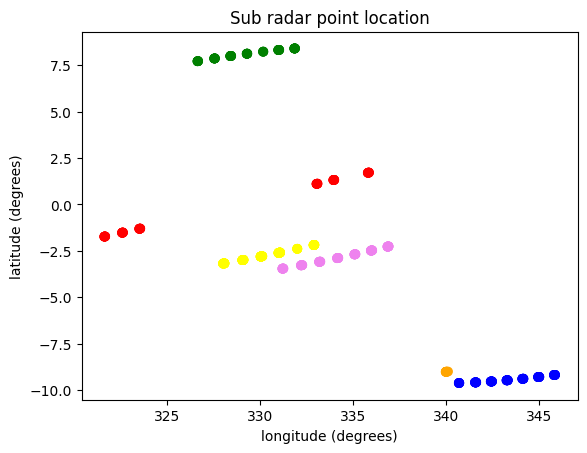

In [30]:
if 0: # debug: Compare ephemeris data
    YEAR = []
    NP_ANG_DEG = []
    NP_DIS_ARCSEC = []
    SRP_LON_DEG_HORIZONS = []
    SRP_LAT_DEG_HORIZONS = []
    RANGE_HORIZONS = []
    AZ_DEG = []
    EL_DEG = []

    SRP_LON_DEG_POLIASTRO = []
    SRP_LAT_DEG_POLIASTRO = []
    END_SRP_LON_DEG_POLIASTRO = []
    END_SRP_LAT_DEG_POLIASTRO = []
    DOP_ANG_DEG_POLIASTRO = []
    DOP_ANG_DEG_POLIASTRO_LIGHTTIME = []

    for f in os.listdir(DATA_PREFIX):
        #if not '1988' in f: continue
        #if not '2015' in f: continue
        #if not '2017' in f: continue
        #if not '2020' in f: continue
        if not "scp" in f: continue
        if not f.endswith('horizons.pkl'): continue
        lbl_dict = parseLbl(f)
        #if lbl_dict['GEO_POINTING'] != "N": continue

        YEAR.append(lbl_dict['START_TIME'][:4])
        hdata = loadOrFetchHorizonsData(f)
        print(f)
        eph = hdata['ephemerides']
        NP_ANG_DEG.append(eph['NPole_ang'][0])
        NP_DIS_ARCSEC.append(eph['NPole_dist'][0])
        SRP_LON_DEG_HORIZONS.append(eph['PDObsLon'][0])
        SRP_LAT_DEG_HORIZONS.append(eph['PDObsLat'][0])
        AZ_DEG.append(eph['AZ'][0])
        EL_DEG.append(eph['EL'][0])
        RANGE_HORIZONS.append((eph['delta'][0] * eph['delta'].unit).to(au.m).value)

        start_astrotime = at.Time(lbl_dict['START_TIME'])
        end_astrotime = at.Time(lbl_dict['STOP_TIME'])

        obs_astrotime = start_astrotime
        #obs_astrotime = start_astrotime - eph['lighttime'][0] * eph['lighttime'].unit
        #obs_astrotime = start_astrotime + (end_astrotime - start_astrotime) / 2
        #obs_astrotime = start_astrotime + (end_astrotime - start_astrotime) / 2 - eph['lighttime'][0] * eph['lighttime'].unit
        #obs_astrotime = end_astrotime

        srp_lon, srp_lat = subRadarPointLonLat_poliastro(obs_astrotime)
        SRP_LON_DEG_POLIASTRO.append(srp_lon.to(au.deg).value)
        SRP_LAT_DEG_POLIASTRO.append(srp_lat.to(au.deg).value)

        obs_astrotime = end_astrotime
        srp_lon, srp_lat = subRadarPointLonLat_poliastro(obs_astrotime)
        END_SRP_LON_DEG_POLIASTRO.append(srp_lon.to(au.deg).value)
        END_SRP_LAT_DEG_POLIASTRO.append(srp_lat.to(au.deg).value)

        doppler_angle = apparentRotationAngleDelta_poliastro(obs_astrotime)
        DOP_ANG_DEG_POLIASTRO.append(doppler_angle.to(au.deg).value)

        doppler_angle = apparentRotationAngleDelta_poliastro_lighttime(obs_astrotime)
        DOP_ANG_DEG_POLIASTRO_LIGHTTIME.append(doppler_angle.to(au.deg).value)


if 0: # debug
    #pl.plot(NP_DIS_ARCSEC)
    #pl.plot(NP_ANG_DEG)
    #pl.plot(DOP_ANG_DEG)
    #NP_ANG = np.array(NP_ANG)
    #pl.plot(np.where(NP_ANG > 180, NP_ANG - 360, NP_ANG))
    #pl.plot(SRP_LAT)

    ## Compare poliastro and horizons doppler angles -- Horizons is currently known broken...
    #pl.figure()
    #pl.plot(DOP_ANG_H_DEG, DOP_ANG_P_DEG, 'x')
    #pl.title('JPL Horizons vs poliastro doppler angles (degrees)')

#    pl.figure()
#    pl.plot(YEAR, np.array(RANGE_HORIZONS), '.')
#    pl.title('Range (m) by year')
#
#    # Sanity check: Campbell says that doppler angles should be <~10 degrees.
#    # After fixing doppler angle calculation, I now see them all below <~6 degrees.
#    pl.figure()
#    pl.hist(np.array(DOP_ANG_DEG_POLIASTRO) - 180.0)
#    pl.title('Histogram of doppler angles (degrees)')
#
#    pl.figure()
#    pl.plot(YEAR, np.array(DOP_ANG_DEG_POLIASTRO) - 180.0, '.')
#    pl.title('Doppler angles (degrees) by year')
#
#    # Sanity check: Doppler angle with and without lighttime should be pretty close.
#    pl.figure()
#    pl.plot(np.array(DOP_ANG_DEG_POLIASTRO) - np.array(DOP_ANG_DEG_POLIASTRO_LIGHTTIME), '.')
#    pl.title('Difference (degrees) in doppler angles with and without lighttime')

    # Sanity check: sub radar points should be within ~10 degrees of the Venusian equator
    pl.figure()
    YC = {
        '1988': 'red',
        '2001': 'orange',
        '2012': 'yellow',
        '2015': 'green',
        '2017': 'blue',
        '2020': 'violet',
          }
    #pl.plot(SRP_LON_DEG_POLIASTRO, SRP_LAT_DEG_POLIASTRO, [YC[y] for y in YEAR], label='poliastro')
    #pl.plot(SRP_LON_DEG_POLIASTRO, SRP_LAT_DEG_POLIASTRO, ["ro",] * len(YEAR), label='poliastro')
    pl.scatter(SRP_LON_DEG_POLIASTRO, SRP_LAT_DEG_POLIASTRO, c=[YC[y] for y in YEAR], label='poliastro')
    #pl.scatter(SRP_LON_DEG_POLIASTRO, SRP_LAT_DEG_POLIASTRO, c=[int(y) for y in YEAR], label='poliastro')
    #pl.plot(SRP_LON_DEG_HORIZONS, SRP_LAT_DEG_HORIZONS, "gx", label='Horizons')
    #pl.legend()
    pl.axis('scaled')
    pl.title('Sub radar point location')
    pl.xlabel('longitude (degrees)') 
    pl.ylabel('latitude (degrees)') 
#
#    # Sanity check: sub radar points from the two methods should be very close
#    pl.figure()
#    pl.plot(np.array(SRP_LON_DEG_POLIASTRO) - np.array(SRP_LON_DEG_HORIZONS), np.array(SRP_LAT_DEG_POLIASTRO) - np.array(SRP_LAT_DEG_HORIZONS), ".")
#    pl.title('Sub radar point difference (poliastro - horizons)')
#    pl.xlabel('longitude (degrees)') 
#    pl.ylabel('latitude (degrees)') 
#    
#    # Sanity check: sub radar points from the two methods should be very close
#    pl.figure()
#    pl.plot(np.array(SRP_LON_DEG_POLIASTRO) - np.array(END_SRP_LON_DEG_POLIASTRO), np.array(SRP_LAT_DEG_POLIASTRO) - np.array(END_SRP_LAT_DEG_POLIASTRO), ".")
#    pl.title('Sub radar point difference (start - end)')
#    pl.xlabel('longitude (degrees)') 
#    pl.ylabel('latitude (degrees)') 
#
#    # Sanity check: elevation should be close to the zenith for Arecibo!
#    pl.figure()
#    pl.plot(AZ_DEG, EL_DEG, '.')
#    pl.title("Az/El")

### Image processing functions

In [ ]:
if _interactive:  # Load doppler delay image
    # File format an 8191 * 8192 array of pixels, each pixel is a complex number represented by real, imaginary components stored as single-precision floats.
    img = np.memmap(DATA_PREFIX + filename, dtype="<F", shape=(8191, 8192), mode="r")  # 'F' is complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.
    print(f"Loaded {filename}")
    print(f"{img.shape=}")
    
    # ??? HACK: 1988 and 2020 data seems to have flipped doppler!?
    if lbl_dict['START_TIME'].startswith('1988') or lbl_dict['START_TIME'].startswith('2020'):
        img = np.fliplr(img)

In [ ]:
# Function: first step of doppler delay image processing pipeline
def coarsePreprocessImage(img):
    c2 = img.shape[1] // 2
    ## Convert complex valued image to magnitude image.
    img_a = np.abs(img)
    ## Normalize the image    
    img_a -= img_a.min()
    img_a /= img_a.max()
    ## Roll the frequency axis (left/right) by the default so that zero doppler is in the middle of the image, and the
    # planet looks like a planet.
    # NOTE: this is NOT a fine-tuned fit but should be correct to within ~100 columns.
    img_a = np.roll(img_a, c2)
    return img_a


if _interactive:
    img_a = coarsePreprocessImage(img)

    if 0: # debug -- pretty dark until further processing!
        #imwrite(filename + ".png", img_a)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_a, cmap='gray')

In [ ]:
# Function: second step of doppler delay image processing pipeline
def coarseTuneRollup(img_a, filename=None):
    c2 = img_a.shape[1] // 2
    ## Roll the range axis (up/down) so that SRP onset starts at row 0
    # First, identify the biggest peak in the center-slice of the image.
    c = np.sum(img_a[:, 3500:-3500], axis=1)
    max_c = np.argmax(c)
    # Center the biggest peak to avoid wrapping issues.
    center_i = c2 - max_c
    c = np.roll(c, center_i)
    # Find the first big increase above the noise floor
    w = 200
    w2 = w // 2
    if 1: # Default
        d = np.diff(c[c2 - w:c2 + 1])
    else: # Useful for very low signal images
        d = c[c2 - w:c2 + 1]
        d -= np.mean(d)
    d_pre_std = np.std(d[:c2 - w2])  # std from samples *before* the spike
    first_i = np.argwhere(d > d_pre_std * 2)[0][0]
    best_rollup = -(max_c - w + first_i) - 1
    if filename: # save a debug file, which also can be used to later look up the best roll
        img_tmp = np.roll(img_a, best_rollup, axis=0)
        os.makedirs(f"{ROOT_PREFIX}/ROLLUP_TRIAGE", exist_ok=True)
        imwrite(f"{ROOT_PREFIX}/ROLLUP_TRIAGE/{filename[:-4]}_rollup_{best_rollup}.png", img_tmp[:500, 3000:-3000])
    return best_rollup


if _interactive:
    coarse_rollup = coarseTuneRollup(img_a)
    print(f"{coarse_rollup=}")
    print(f"{lbl_dict['GEO_DELAY_OFFSET']=}")
    img_a = np.roll(img_a, coarse_rollup, axis=0)

    if 0: # debug -- pretty dark until further processing!
        #imwrite(filename + ".png", img_a)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_a, cmap='gray')

In [ ]:
if 0:  # Experiment with scaling logarithmically
    img_l = np.log10(img_a)
    img_l[img_l<-2] = -2
    img_l[img_l>-0.5] = -0.5
    
    pl.figure(figsize=(16, 16))
    pl.axis('off')
    pl.imshow(img_l, cmap='gray')
    
    pl.figure(figsize=(16, 4))
    pl.hist(img_l.ravel(), bins=50)

In [ ]:
# Function: third step of doppler delay image processing pipeline
def normalizeOcpImageByRange(img_a, filename=None):
    echo_power = 10 / np.linspace(1, 1000, img_a.shape[0]) + 0.04
    img_b = (img_a.T / echo_power).T
    return img_b

def clipImage(img_b, filename=None):
    # Clip the 99th percentile pixel brightness
    percentile = 99
    percentile_thresh = np.percentile(img_b.ravel(), percentile)
    img_b = np.where(img_b > percentile_thresh, percentile_thresh, img_b)

    #percentile = 5
    #percentile_thresh = np.percentile(img_b.ravel(), percentile)
    #img_b = np.where(img_b < percentile_thresh, percentile_thresh, img_b)

    if filename:
        os.makedirs(f"{ROOT_PREFIX}/PREPROCESS_TRIAGE", exist_ok=True)
        imwrite(f"{ROOT_PREFIX}/PREPROCESS_TRIAGE/{filename[:-4]}.png", img_b)

    return img_b


if _interactive:
    if 'ocp' in filename:
        img_a = normalizeOcpImageByRange(img_a)
    img_a = clipImage(img_a)

    if 1:  # debug -- image should look pretty good!
        #imwrite(filename + ".png", img_b)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_a, cmap='gray')

    if 1:  # debug brightness histogram
        pl.figure(figsize=(16, 4))
        pl.hist(img_a.ravel(), bins=50)

In [ ]:
# Function: fourth step of doppler delay image processing pipeline
def coarseTuneRoll(img_b, baud, filename=None): # Coarse-tune the centering by rolling to maximize left-right symmetry
    best_col_offset = 0
    best_col_offset_sum = 0
    # Baud (and radial velocity) roughly determines the frequency spreading, so we use different windows to avoid the wrap region.
    # TODO: switch to using radial velocity, baud isn't the right thing!
    if baud == 4.2:  # 2001
        img_h = img_b[2800:3800, :].copy()
    elif baud == 4.0:  # 1988
        img_h = img_b[3000:4000, :].copy()
    elif baud == 3.9:  # 2017
        img_h = img_b[4000:5000, :].copy()
    elif ('_2012' in filename or '_2020' in filename) and baud == 3.8:  # For 2012
        img_h = img_b[3500:4500, :].copy()
    elif baud == 3.8:  # 2015
        img_h = img_b[4000:5000, :].copy()
    else:
        raise ValueError("Unknown baud", baud)
    if '_1988' in filename:
        offset_range = range(-100, 101)
    else:
        offset_range = range(-50, 51)
    for offset in offset_range:
        img_tmp = np.roll(img_h, offset)
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        total_sum = np.sum(img_mirror)
        if total_sum > best_col_offset_sum:
            best_col_offset_sum = total_sum
            best_col_offset = offset
    if filename: # save a debug file, which also can be used to later look up the best roll
        img_tmp = np.roll(img_h, best_col_offset)
        img_mirror = img_tmp[:, :1000] * np.fliplr(img_tmp[:, -1000:])
        os.makedirs(f"{ROOT_PREFIX}/ROLL_TRIAGE", exist_ok=True)
        imwrite(f"{ROOT_PREFIX}/ROLL_TRIAGE/{filename[:-4]}_roll_{best_col_offset}.png", img_mirror)
    return best_col_offset
    
if _interactive:
    best_col_offset = coarseTuneRoll(img_b, lbl_dict['GEO_BAUD'])
    print(f'{best_col_offset=}')
    img_b = np.roll(img_b, best_col_offset)

    if 1: # debug
        #imwrite(filename + ".png", img_b)
        pl.figure(figsize=(16, 16))
        pl.axis('off')
        pl.imshow(img_b + np.fliplr(img_b), cmap='gray')

In [ ]:
# Function: fit parameters to the doppler/delay image curve

def curveRowsAndCols(c2, freq_offset, delay_offset, freq_scale, sin_dlon, row_dist):
    # Utility function
    cs = (c2 * freq_scale) * sin_dlon + (c2 + freq_offset)
    rs = row_dist + delay_offset
    rs = rs.astype('i')
    cs = cs.astype('i')
    
    ### Simple offset
    #rs2 = rs
    #cs2 = np.where(cs < c2, cs - 2, cs + 2)  # TODO: smarter kernel?

    # Orthogonal offset
    drs = np.diff(rs, append=rs[-1])
    dcs = np.diff(cs, append=cs[-1])
    cs2 = cs + np.clip(drs, -1, 1)
    rs2 = rs - np.clip(dcs, -1, 1)

    rs2 = rs2.astype('i')
    cs2 = cs2.astype('i')
    return rs, cs, rs2, cs2


def fitDopplerDelayCurve(img_b, baud, filename=None):
    c2 = img_b.shape[1] / 2
    _radius_km = 6051.8  # Venus radius
    _row_dist_km = 299792.46 * baud * 1e-6 / 2 # c * dt / 2  Note: row is *round-trip-time* (double distance)
    dlon = np.linspace(-np.pi/2, np.pi/2, 8000)
    row_dist = _radius_km * (1 - np.cos(dlon)) / _row_dist_km
    sin_dlon = np.sin(dlon)

    # Grid search by looking for the best "edge"
    best_score = -np.inf
    best_params = []
    #for freq_offset in (0,):
    #    for delay_offset in (0,):
    #        for freq_scale in (1.0,):
    for freq_offset in range(-3, 4):  # Small range because image has already been coarsely centered.
        for delay_offset in range(-3, 4):  # Small range because image has already been coarsely ranged.
    #for freq_offset in range(-10, 11):  # larger range because image has already been coarsely centered.
    #    for delay_offset in range(-10, 11):  # larger range because image has already been coarsely ranged.
            for freq_scale in np.linspace(0.9, 1.4, 301):
                rs, cs, rs2, cs2 = curveRowsAndCols(c2, freq_offset, delay_offset, freq_scale, sin_dlon, row_dist)
                row_start = 500 # NOTE: start at row_start to avoid bias due to extremely bright SRP return
                row_end = 8000  # NOTE: end at row_end to avoid noise due to frequency wrapping
                valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= row_start) & (rs < row_end)
                valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs2 >= row_start) & (rs2 < row_end)
                score = sum(img_b[rs[valid], cs[valid]]) - sum(img_b[rs2[valid2], cs2[valid2]])
                if score > best_score:
                    best_score = score
                    best_params = [freq_offset, delay_offset, freq_scale]
    if filename: # save a debug file, which can also be used to later look up the fit parameters
        freq_offset, delay_offset, freq_scale = best_params
        rs, cs, rs2, cs2 = curveRowsAndCols(c2, freq_offset, delay_offset, freq_scale, sin_dlon, row_dist)
        valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0]) 
        valid2 = (cs2 >= 0) & (cs2 < img_b.shape[1]) & (rs2 >= 0) & (rs2 < img_b.shape[0])   
        img_h = img_b.copy() # Scratch image
        img_h[rs2[valid2], cs2[valid2]] = img_h.min() / 2
        img_h[rs[valid], cs[valid]] = img_h.max() * 2
        os.makedirs(f"{ROOT_PREFIX}/FIT_TRIAGE", exist_ok=True)
        imwrite(f"{ROOT_PREFIX}/FIT_TRIAGE/{filename[:-4]}_fit_{freq_offset}_{delay_offset}_{freq_scale}.png", img_h)
    return best_score, best_params


if _interactive:
    best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_b, lbl_dict['GEO_BAUD'], "interactive_" + filename)
    freq_offset, delay_offset, freq_scale = best_fit_parameters
    print(f'Best fit score: {best_fit_score:.4f}')
    print(f'Best fit parameters: {freq_offset}, {delay_offset}, {freq_scale:.4f}')

In [ ]:
# Function: spherical to planar projection utility functions

# lon in [0, 2*pi)
# lat in [-pi/2, pi/2]

## 0 longitude at the left edge of the map
#def setLLV(G, Gc, lon, lat, v):
#    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
#    c = (lon / (2 * np.pi) * G.shape[1]).astype('i')
#    G[r, c] = v
#    Gc[r, c] = 1
#
#def addLLV(G, Gc, lon, lat, v):
#    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
#    c = (lon / (2 * np.pi) * G.shape[1]).astype('i')
#    G[r, c] += v
#    Gc[r, c] += 1

### 0 longitude in the middle of the map
#def setLLV(G, Gc, lon, lat, v):
#    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
#    c = ((lon + np.pi) / (2 * np.pi) * G.shape[1]).astype('i')  # Shift 0 to the middle of the map
#    G[r, c] = v
#    Gc[r, c] = 1
#
#def addLLV(G, Gc, lon, lat, v):
#    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
#    c = ((lon + np.pi) / (2 * np.pi) * G.shape[1]).astype('i')  # Shift 0 to the middle of the map
#    G[r, c] += v
#    Gc[r, c] += 1

# 0 longitude in the center of the map, lon in [0, pi)
def setLLV(G, Gc, lon, lat, v):
    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
    c = ((lon + np.pi / 2) / np.pi * G.shape[1]).astype('i')
    G[r, c] = v
    Gc[r, c] = 1

def addLLV(G, Gc, lon, lat, v):
    r = ((lat + np.pi / 2) / np.pi * G.shape[0]).astype('i')
    c = ((lon + np.pi / 2) / np.pi * G.shape[1]).astype('i')
    G[r, c] += v
    Gc[r, c] += 1

In [ ]:
if 0:  # debug: Draw debug lines of latitude and longitude
    #setLLV(G0, Gc, np.linspace(0, 359, 100), np.linspace(-90, 89, 100), 1)
    #setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, 1)
    setLLV(G, Gc, np.linspace(0, 359, 1000) / 180 * np.pi, np.linspace(66, 67, 1000) / 180 * np.pi, G.max())

In [ ]:
## Project the doppler-delay image into a global lon/lat map
import astropy.coordinates as ac
import astropy.units as au

def dopplerDelayToSphericalProjection(img_b, G, Gc,
                                      baud, pointing, 
                                      srp_lon,
                                      srp_lat,
                                      freq_offset,
                                      delay_offset,
                                      freq_scale,
                                      doppler_angle):
    # Omit "degraded data" regions due to
    # - high N/S ambiguity near the edges (first few degrees of latitude), and
    # - grazing angle (last few degrees of latitude and longitude)
    dlon = np.linspace(-85 / 180 * np.pi, 85 / 180 * np.pi, 16000)
    if pointing == 'N':
        dlat = np.linspace(5 / 180 * np.pi, 85 / 180 * np.pi, 8000)  # Northern hemisphere
    else:
        dlat = np.linspace(-85 / 180 * np.pi, -5 / 180 * np.pi, 8000)  # Southern hemisphere
    dlon_mesh, dlat_mesh = np.meshgrid(dlon, dlat)

    # Omit degraded data region within 7 deg of the SRP due to the very bright returns
    mesh_valid = np.sqrt(dlat_mesh**2 + dlon_mesh**2) > (7 / 180 * np.pi)
    dlon_mesh = dlon_mesh[mesh_valid]
    dlat_mesh = dlat_mesh[mesh_valid]

    c2 = img_b.shape[1] / 2
    cs = (c2 * freq_scale) * np.cos(dlat_mesh) * np.sin(dlon_mesh) + (c2 + freq_offset)
    _radius_km = 6051.8
    _row_dist_km = 299792.46 * baud * 1e-6 / 2 # km  Note: row is *round-trip-time* (double distance)
    rs = (1 - np.cos(dlon_mesh) * np.cos(dlat_mesh)) * (_radius_km / _row_dist_km) + delay_offset

    rs = rs.astype(np.int16)
    cs = cs.astype(np.int16)
    valid = (cs >= 0) & (cs < img_b.shape[1]) & (rs >= 0) & (rs < img_b.shape[0])   
    
    if 0: # No SRP transform: as if the SRP were (0, 0)
        addLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

    if 1: # Transformed to the SRP and rotated by the "doppler angle"
        # Convert to unit spheroid cartesian coordinates.
        cdlat_mesh = np.cos(dlat_mesh)
        X = np.matrix((cdlat_mesh * np.cos(dlon_mesh),
                       cdlat_mesh * np.sin(dlon_mesh),
                       np.sin(dlat_mesh)))

        # The S matrix rotates the coordinate system to center the SRP.
        clon = np.cos(srp_lon)
        clat = np.cos(srp_lat)
        slon = np.sin(srp_lon)
        slat = np.sin(srp_lat)
        S = np.matrix((( clon * clat,  slon * clat, slat),
                       (       -slon,         clon,    0),
                       (-clon * slat, -slon * slat, clat))) 

        ## The D matrix rotates the coordinates about the x axis by the apparent doppler angle:
        cnp = np.cos(doppler_angle.to(au.radian))
        snp = np.sin(doppler_angle.to(au.radian))
        D = np.matrix(((1,   0,    0),
                       (0, cnp, -snp),
                       (0, snp,  cnp))) 

        X = (S.T * D) * X  # HACK really ought to be D.T, but I think I need to flip apparentRotationAngleDelta_poliastro
    
        # Convert back to lat/lon
        dlat_mesh = np.arcsin(X[2].A)[0]
        dlon_mesh = np.arctan2(X[1].A, X[0].A)[0]
        addLLV(G, Gc, dlon_mesh[valid], dlat_mesh[valid], img_b[rs[valid], cs[valid]])

if _interactive:
    G = np.zeros((8000, 16000), dtype='f') # TODO: use a smaller data rep?
    Gc = np.zeros(G.shape, 'int')
    doppler_angle = apparentRotationAngleDelta_poliastro(start_astrotime)
    dopplerDelayToSphericalProjection(img_b, G, Gc,
                                      lbl_dict['GEO_BAUD'], lbl_dict['GEO_POINTING'],
                                      hdata['ephemerides']['PDObsLon'][0],
                                      hdata['ephemerides']['PDObsLat'][0],
                                      freq_offset,
                                      delay_offset,
                                      freq_scale,
                                      doppler_angle)
    Gm = np.divide(G, Gc, where=Gc>0)
    os.makedirs(f"{ROOT_PREFIX}/GLOBAL_TRIAGE", exist_ok=True)
    imwrite(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{filename[:-4]}_global.png", np.flipud(Gm))

    if 1:
        pl.figure(figsize=(20, 10))
        pl.axis('off')
        pl.imshow(Gm[::4, ::4], cmap='gray', origin='lower')
        #pl.imshow(G[::4, ::4], cmap='gray', origin='lower')
        #pl.imshow(G, cmap='gray', origin='lower') # , interpolation='none')

## Full processing pipeline (non-interactive)

In [ ]:
# Caches/filters

#FILTER_PREFIX = ROOT_PREFIX + "FIT_GOOD/"
#FILTER_PREFIX = ROOT_PREFIX + "ROLL_BAD/"
FILTER_PREFIX = ROOT_PREFIX + "FIT_GOOD/"
os.makedirs(FILTER_PREFIX, exist_ok=True)
filenames = os.listdir(FILTER_PREFIX)
FILTER = set()
for filename in filenames:
    FILTER.add(filename[:25])

ROLLUP_CACHE_PREFIX = ROOT_PREFIX + "ROLLUP_GOOD/"
os.makedirs(ROLLUP_CACHE_PREFIX, exist_ok=True)
filenames = os.listdir(ROLLUP_CACHE_PREFIX)
ROLLUP_CACHE = {}
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[33:].split('.')[0])
    ROLLUP_CACHE[filename[:25]] = r

ROLL_CACHE_PREFIX = ROOT_PREFIX + "ROLL_GOOD/"
os.makedirs(ROLL_CACHE_PREFIX, exist_ok=True)
filenames = os.listdir(ROLL_CACHE_PREFIX)
ROLL_CACHE = {}
for filename in filenames:
    if not filename.endswith('.png'): continue
    r = int(filename[31:].split('.')[0])
    ROLL_CACHE[filename[:25]] = r

FIT_CACHE_PREFIX = ROOT_PREFIX + "FIT_GOOD/"
os.makedirs(FIT_CACHE_PREFIX, exist_ok=True)
filenames = os.listdir(FIT_CACHE_PREFIX)
FIT_CACHE = {}
for filename in filenames:
    if not filename.endswith('.png'): continue
    params = filename[30:-4].split("_")
    FIT_CACHE[filename[:25]] = [int(params[0]), int(params[1]), float(params[2])]

#COMPLETE_PREFIX = ROOT_PREFIX + "OCP_GLOBAL_TRIAGE/"
#COMPLETE_PREFIX = ROOT_PREFIX + "FIT_TRIAGE/"
#COMPLETE_PREFIX = ROOT_PREFIX + "ROLL_TRIAGE/"
COMPLETE_PREFIX = ROOT_PREFIX + "PROCESSED_DATA/"
os.makedirs(COMPLETE_PREFIX, exist_ok=True)
filenames = os.listdir(COMPLETE_PREFIX)
COMPLETE = set()
for filename in filenames:
    COMPLETE.add(filename[:25])

In [ ]:
# Full doppler/delay processing pipeline (with caching)
def processDopplerDelayImage(filename, G=None, Gc=None, blendOCP=False):
    if blendOCP: assert('scp' in filename)

    basename = filename[:25]
    basename_for_param_cache = basename.replace('ocp', 'scp')

    if len(FILTER) and not basename_for_param_cache in FILTER:  # Don't apply the filter if it's empty
        print('Filtering', filename, 'aka', basename_for_param_cache)
        return  
#    if basename in COMPLETE:
#        print('Skipping', filename)
#        return
    print('Processing', filename)

    lbl_dict = parseLbl(filename)

#    hdata = loadOrFetchHorizonsData(filename)
#
#    img = np.memmap(DATA_PREFIX + filename, dtype='<F', shape=(8191, 8192), mode='r')  # 'F' is complex single-precision: a complex number type of 2 32-bit precision floating-point numbers.
#    if blendOCP:
#        ocp_filename = filename.replace('scp', 'ocp')
#        ocp_basename = ocp_filename[:25]
#        ocp_img = np.memmap(DATA_PREFIX + ocp_filename, dtype='<F', shape=(8191, 8192), mode='r')

#    # ??? HACK: 1988 and 2020 data seem to have flipped doppler!?
#    if lbl_dict['START_TIME'].startswith('1988') or lbl_dict['START_TIME'].startswith('2020'):
#        img = np.fliplr(img)
#        if blendOCP: ocp_img = np.fliplr(ocp_img)
#
#    # First do basic image processing: convert to magnitude from complex, and normalize.
#    img_a = coarsePreprocessImage(img)
#    if blendOCP: ocp_img_a = coarsePreprocessImage(ocp_img)
#
#    # Second, coarse tune the range (rollup)
#    if basename_for_param_cache in ROLLUP_CACHE:
#        best_rollup = ROLLUP_CACHE[basename_for_param_cache]
#    else:
#        best_rollup = coarseTuneRollup(img_a, filename)
#    img_a = np.roll(img_a, best_rollup, axis=0)
#    # If blendOCP, use the same rollup as SCP, under the theory that SCP is less sensitive to blooming in the SRP region.
#    if blendOCP: ocp_img_a = np.roll(ocp_img_a, best_rollup, axis=0)
#
#    # Third, do image processing (which requires a tuned rollup for OCP normalization)
#    img_a = clipImage(img_a, filename)
#    if blendOCP:
#        ocp_img_a = normalizeOcpImageByRange(ocp_img_a)
#        ocp_img_a = clipImage(ocp_img_a, ocp_filename)
#        
#    # Fourth, tune the symmetry (roll)
#    if basename_for_param_cache in ROLL_CACHE:
#        best_roll = ROLL_CACHE[basename_for_param_cache]
#    else: 
#        best_roll = coarseTuneRoll(img_a, lbl_dict['GEO_BAUD'], filename)
#    img_a = np.roll(img_a, best_roll)
#    # If blendOCP, use the same roll as SCP, for consistency
#    if blendOCP: ocp_img_a = np.roll(ocp_img_a, best_roll)
#
#    if blendOCP:  # Blend for optimal subjective appearance
#        blend = np.concatenate((np.zeros(1000), np.linspace(0, 1, 2000), np.ones(5191)))
#        img_a = (ocp_img_a.T * blend + img_a.T * (1 - blend)).T
#        os.makedirs(f"{ROOT_PREFIX}/BLEND_TRIAGE", exist_ok=True)
#        imwrite(f"{ROOT_PREFIX}/BLEND_TRIAGE/blend_{basename}.png", img_a)
#
#    if 1:  # Cache the processed image
#        processed_basename = basename
#        if blendOCP:
#            processed_basename = basename.replace('scp', 'blend')
#        os.makedirs(f"{ROOT_PREFIX}/PROCESSED_DATA", exist_ok=True)
#        np.save(f"{ROOT_PREFIX}/PROCESSED_DATA/{processed_basename}.npy", img_a.astype(np.float16))  # Is float16 enough?
#
#    return ######
    
    img_a = np.load(f"{ROOT_PREFIX}/PROCESSED_DATA/{basename}.npy").astype(np.float32)

    print('  fitting', basename)
    if basename_for_param_cache in FIT_CACHE:
        freq_offset, delay_offset, freq_scale = FIT_CACHE[basename_for_param_cache]  # Use cached params
    else:
        best_fit_score, best_fit_parameters = fitDopplerDelayCurve(img_a, lbl_dict['GEO_BAUD'], filename)
        freq_offset, delay_offset, freq_scale = best_fit_parameters

    standalone_image = G is None or Gc is None
    if standalone_image: # Create new global map image and count image
        G = np.zeros((16000, 16000), dtype=np.float32) # TODO: use a smaller data rep?
        Gc = np.zeros(G.shape, dtype=np.int16)

    print('  projecting', basename)
    # Use the mid-point of the observation window as the observation time.
    start_astrotime = at.Time(lbl_dict['START_TIME'])
    end_astrotime = at.Time(lbl_dict['STOP_TIME'])
    obs_astrotime = start_astrotime + (end_astrotime - start_astrotime) / 2

    doppler_angle = apparentRotationAngleDelta_poliastro(obs_astrotime)
#    # Horizons SRP
#    srp_lon = hdata['ephemerides']['PDObsLon'][0] * au.deg
#    srp_lat = hdata['ephemerides']['PDObsLat'][0] * au.deg
    # Poliastro SRP
    srp_lon, srp_lat = subRadarPointLonLat_poliastro(obs_astrotime)
    dopplerDelayToSphericalProjection(img_a, G, Gc,
                                      lbl_dict['GEO_BAUD'],
                                      lbl_dict['GEO_POINTING'],
                                      srp_lon,
                                      srp_lat,
                                      freq_offset,
                                      delay_offset,
                                      freq_scale,
                                      doppler_angle)

    if standalone_image:
        print('  saving', basename)
        np.divide(G, Gc, out=G, where=Gc>0)  # Divide in place to save memory
        os.makedirs(f"{ROOT_PREFIX}/OCP_GLOBAL_TRIAGE", exist_ok=True)
#        imwrite(f"{ROOT_PREFIX}/GLOBAL_TRIAGE/{basename}.png", np.flipud(G.T))
        imwrite(f"{ROOT_PREFIX}/OCP_GLOBAL_TRIAGE/{ocp_basename}_rot_{Venus.rotational_period:0.6f}.png", np.flipud(G))

## Batch and commandline processing

In [ ]:
if 0: # Process specific files
    #processDopplerDelayImage("venus_scp_20150811_174505.img")
    #processDopplerDelayImage("venus_ocp_20150816_171104.img")
    #processDopplerDelayImage("venus_ocp_19880617_151830.img")
    #processDopplerDelayImage("venus_scp_20150812_155242.img")
    #processDopplerDelayImage("venus_scp_20150815_170058.img")
    print(Venus.rotational_period)
    processDopplerDelayImage("venus_scp_19880617_145820.img", blendOCP=True)  # First northern hemisphere look in the dataset
    processDopplerDelayImage("venus_scp_20170326_171855.img", blendOCP=True)  # Last northern hemisphere look in 2017 (2020 data is lower quality)

In [ ]:
if 0: # Batch processing in notebook (only one-at-a-time, see parallel execution magic below!)
    import os
    for filename in os.listdir(DATA_PREFIX):
        if not filename.endswith('.img'): continue
        #if not '_2012' in filename: continue
        if not '_2001' in filename: continue
        processDopplerDelayImage(filename)

In [ ]:
if 0: # Combine specific images into a single global projection
    G = np.zeros((8000, 8000), dtype=np.float32) # TODO: use float16?
    Gc = np.zeros(G.shape, dtype=np.int16)
    file1 = "venus_scp_19880617_145820.img"  # First northern hemisphere look in the dataset
    file2 = "venus_scp_20170326_171855.img"  # Last northern hemisphere look in 2017 (2020 data is lower quality)
    #file1 = "venus_scp_20150810_162629.img"
    #file2 = "venus_scp_20170327_165650.img" 
    processDopplerDelayImage(file1, G, Gc, blendOCP=True)
    processDopplerDelayImage(file2, G, Gc, blendOCP=True)
    np.divide(G, Gc, out=G, where=Gc>0)  # Divide in place to save memory
    os.makedirs(f"{ROOT_PREFIX}/SUPERRESOLUTION_TRIAGE", exist_ok=True)
    imwrite(f"{ROOT_PREFIX}/SUPERRESOLUTION_TRIAGE/pair_{file1[:25]}_{file2[:25]}.png", np.flipud(G))

if 1: # Combine specific images into a single global projection
    imageSets = {
#        '1988': [
#            "venus_scp_19880617_145820.img", # First northern hemisphere look in the dataset
#            "venus_scp_19880617_150830.img", # ... next three consecutive observations
#            "venus_scp_19880617_151830.img",
#            "venus_scp_19880617_154030.img",
#        ],
#        '2001': [
#            "venus_scp_20010331_150010.img",
#            "venus_scp_20010331_152438.img",
#            "venus_scp_20010331_154838.img",
#            "venus_scp_20010331_161248.img",
#        ],
#        '2012': [
#            "venus_scp_20120529_162029.img",
#            "venus_scp_20120529_162444.img",
#            "venus_scp_20120529_162859.img",
#            "venus_scp_20120529_163314.img",
#        ],
        '2015': [
            "venus_scp_20150815_172030.img",
            "venus_scp_20150815_171044.img",
            "venus_scp_20150815_170058.img",
            "venus_scp_20150815_165112.img",
        ],
#        '2017': [
#            "venus_scp_20170326_171855.img",  # Last northern hemisphere look in 2017 (2020 data is lower quality)
#            "venus_scp_20170326_170923.img",  # ... prior three consecutive observations
#            "venus_scp_20170326_165951.img",
#            "venus_scp_20170326_164409.img",
#        ],
#        '2020': [
#            "venus_scp_20200530_174429.img",
#            "venus_scp_20200530_173437.img",
#            "venus_scp_20200530_172445.img",
#            "venus_scp_20200530_171453.img",
#        ],
    }
    for key, filenames in imageSets.items():
        resolution = 16000
        output_name = f'hemisphere_venus_scp_{key}_4stack_rot_{Venus.rotational_period:0.6f}_ra_{poliastro.core.fixed.k_venera_ra:0.3f}_dec_{poliastro.core.fixed.k_venera_dec:0.3f}_res_{resolution}'
        output_path = f"{ROOT_PREFIX}/PARAM_4STACK_TRIAGE/{output_name}.png"
        if os.path.exists(output_path):
            print(f'skipping existing {output_name}')
            continue
        print(f'Processing image set for {output_name}')
        G = np.zeros((resolution, resolution), dtype=np.float32)
        Gc = np.zeros(G.shape, dtype=np.int16)
        for filename in filenames:
            processDopplerDelayImage(filename, G, Gc)  # , blendOCP=True)
        np.divide(G, Gc, out=G, where=Gc>0)  # Divide in place to save memory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        imwrite(output_path, np.flipud(G))

if 0: # Combine a large set of images into a super-resolution image
    resolution = 24000
    pattern = 'venus_ocp_2015' 
    output_name = f'hemisphere_{pattern}_rot_{Venus.rotational_period:0.6f}_ra_{poliastro.core.fixed.k_venera_ra:0.3f}_dec_{poliastro.core.fixed.k_venera_dec:0.3f}_res_{resolution}'
    output_path = f"{ROOT_PREFIX}/PARAM_FULLSTACK_TRIAGE/{output_name}.png"
    # if os.path.exists(output_path):
    #     print(f'skipping existing {output_name}')
    #     continue
    G = np.zeros((resolution, resolution), dtype=np.float32)
    Gc = np.zeros(G.shape, dtype=np.int16)
    #pattern = 'venus_scp_20150815' 
    # pattern = 'venus_scp_1988' 
    # for filename in os.listdir(DATA_PREFIX):
    #     if not filename.endswith('.img'): continue
    #     if not pattern in filename: continue
    #     processDopplerDelayImage(filename, G, Gc, blendOCP=True)
    for filename in os.listdir(DATA_PREFIX):
        if not filename.endswith('.img'): continue
        if not pattern in filename: continue
        processDopplerDelayImage(filename, G, Gc) #, blendOCP=True)
    # pattern = 'venus_scp_2017' 
    # for filename in os.listdir(DATA_PREFIX):
    #     if not filename.endswith('.img'): continue
    #     if not pattern in filename: continue
    #     processDopplerDelayImage(filename, G, Gc, blendOCP=True)
    #pattern = f'hemisphere_venus_ocp_rot_period_{Venus.rotational_period}_res_{resolution}_1988'
    #pattern = f'hemisphere_venus_ocp_rot_{Venus.rotational_period}_res_{resolution}_1988-2015-2017'
    np.divide(G, Gc, out=G, where=Gc>0)  # Divide in place to save memory
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    imwrite(output_path, np.flipud(G))

In [ ]:
## Main function to allow being run from the command-line.
import sys

if 1:
    sys.exit()

if __name__ == '__main__' and "get_ipython" not in dir():  # Not imported, not run from Jupyter/IPython
    args = sys.argv[1:]
    #print('args', args)
    #processDopplerDelayImage(args[0], blendOCP=True)
    processDopplerDelayImage(args[0])
    sys.exit()

In [ ]:
## Parallel self-running magic.

## 1. Convert to .py:
! jupyter nbconvert --to python process_radar_images.ipynb

## 2. Run the .py in parallel (using the main function above):
## TODO: reduce memory usage to allow more parallel instantiations! (Can only run 4 with ~32 GB of RAM)
! ls -1 $DATA_PREFIX/*.img | xargs -n 1 basename | xargs -n 1 -P 8 python3 process_radar_images.py

# Analysis

## Hunting down registration errors

There appears to be a significant amount of residual error when projecting the doppler/range images into global coordinates and then trying to stack them.

Campbell et al didn't try to chase down these errors (personal communication), and instead fit the images to known anchor points. (did they set up an under-constrained problem?). One interesting data point is that Campbell's fitted doppler angles are all around 10 degrees, whereas my doppler angles derived from ephemeris data is often as much as 20 degrees. Given the error characteristics of the ephemeris data (see discussion below), it does not seem plausible for there to be 10 degrees of error!

This seems unsatisfactory to me: the physics of this experiment are pretty clean, and so the projections should be 

There are two ways to hunt for the sources of error -- and it is likely that there are multiple. The first is to double-check the processing pipeline for mistakes. The second is to characterize the *expected* error due to each source and then compare these expectations with the actual observed error to see if it is fully explained.

## Known error sources
1. My fit parameters. Specifically, sub-radar point range (called rollup and delay_offset in the code), range rate (called roll and freq_offset in the code), and doppler spreading (called freq_scale in the code). Due to unknown offsets used during the original data collection process, delay_offset and freq_offset parameters can't be absolutely determined, and must be calculated by fitting. On the other hand, they *should* be robust to fitting. Freq_scale on the other hand should be directly correlated with the "lateral" relative observer velocity.

[DONE: calculate expected freq_scale and compare with the fit results.  -->  See analysis above.]

[TODO: calculate expected projection error sensitivity due to errors in delay_offset and freq_offset)]

2. The ephemeris projections. Both JPL Horizons and poliastro use the DE44X family. From https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf, orbital position of Venus is estimated to have an rms residual of about 8 m. From https://escholarship.org/content/qt2dn1012s/qt2dn1012s.pdf?t=pv3anr, errors in the DE44X rotation rate for Venus amount to approximately 0.2 degrees over 30 years.

[NOTE: I don't yet have an estimate of error for the axis of Venus]

In general,
- error in the planetary position would result in projected errors in the SRP and thus joint lat/lon errors... but perhaps mostly in longitude.
- error in the rotation rate would result in projected errors in longitude.
- error in the polar axis would result in errors in latitude and doppler angle.

## Potential error sources
1. My transformation code
2. My doppler angle calculation code
3. Some type of time error (wrong time zone? JD to TBD?)
4. Some missing systematic correction factor, that is not included in the standard descriptions of the doppler/delay image processing pipeline.
5. Some missing noise factor that can cause minute-to-minute, day-to-day, or year-to-year error. Examples could be perturbations due to atmospheric or magnetospheric conditions, issues with the radio telescope.

[TODO: one way to chase down possible noise factors is to look at the noise characteristics of the projected images, and see what sort of time constants the noise appears to have. If the noise is small minute-to-minute but large year-to-year, that helps us constrain the likely sources.]

In [ ]:
if 0: # debug: Compare "orthogonal" velocity to freq_scale
    FILENAME = []
    FREQ_OFFSET = []
    DELAY_OFFSET = []
    FREQ_SCALE = []
    ORTHO_VEL = []
    GEO_BAUD = []
    filenames = os.listdir(ROOT_PREFIX + "FIT_TRIAGE_2/")
    for filename in filenames:
        if not filename.endswith('.png'): continue
        params = filename[30:-4].split("_")
        lbl_dict = parseLbl(filename[:25])
        SRP = pickle.load(open(DATA_PREFIX + filename[:25] + '_horizons.pkl', 'rb'))
        start_astrotime = SRP['start_astrotime']

        FILENAME.append(filename[:25])
        FREQ_OFFSET.append(int(params[0]))
        DELAY_OFFSET.append(int(params[1]))
        FREQ_SCALE.append(float(params[2]))
        GEO_BAUD.append(lbl_dict['GEO_BAUD'])
        ORTHO_VEL.append(orthogonalVelocity_poliastro(start_astrotime))

    FREQ_OFFSET = np.array(FREQ_OFFSET)
    DELAY_OFFSET = np.array(DELAY_OFFSET)
    FREQ_SCALE = np.array(FREQ_SCALE)
    ORTHO_VEL = np.array(ORTHO_VEL)
    GEO_BAUD = np.array(GEO_BAUD)

if 0:
    #pl.figure(figsize=(12,12))
    #pl.plot(FREQ_SCALE)
    #pl.plot(ORTHO_VEL)
    for y in ("1988", "2001", "2012", "2015", "2017", "2020"):
    #for y in [f"201508{i:02d}" for i in range(10, 17)]:
    #for y in [f"201703{i:02d}" for i in range(21, 28)]:
        m = [f"_{y}" in x for x in FILENAME]
        #pl.plot(FREQ_OFFSET[m], '.', label=y)
        #pl.plot(DELAY_OFFSET[m], '.', label=y)
        #pl.plot(ORTHO_VEL[m], '.', label=y)
        pl.plot(1 / FREQ_SCALE[m] * GEO_BAUD[m], ORTHO_VEL[m], '.', label=y)
    pl.legend()
    pl.title('Baud-corrected fit scale factor vs "orthogonal" velocity')
#    pl.title('"orthogonal" velocity')

While the delay-offset and frequency-offset are likely not recoverable due to how the data files were created, the frequency-scale *should* be something we can calculate directly. The frequency-scale factor is directly related to the "orthogonal" velocity -- the component of Venus-to-observer motion that is perpendicular to the line between the two. The higher this orthogonal velocity, the higher the apparent velocity of the limbs, symmetrically.

We do need to correct the bandwidth for different years using their baud rate.

| Year | Baud rates (microseconds) |
| ---- | ------------------------- |
| 1988 | 4.0 |
| 2001 | 4.2 |
| 2012 | 3.8 |
| 2015 | 3.8 |
| 2017 | 3.9 |
| 2020 | 3.8 |

As a result, fit-frequency-scale / baud should be proportional to orthogonal velocity.

All of the years line up nicely *except* 2015 and 2017, which seem to have a time-varying bias. 2015 in particular has the same baud as 2012 and 2020.
Was there some approximate correction frequency-scale factor applied during the 2015 and 2017 observation seasons?

Another possiblity is that there is some sort of systematic fit error that is affecting only the 2015 and 2017 looks.

From "Arecibo Radar Maps of Venus from 1988 to 2020": 
"Two methods were used to compensate for the gross
Doppler shift between the observing station and Venus. For the
1988 data, no compensation was applied during the observations,
so an optimum change in Doppler frequency with time was
derived using an autofocus technique during the correlation with
the PN code. For all later data, ephemerides provided by different
programs were used to impose a time-varying frequency shift to
place the subradar location on Venus at zero Doppler."

Taken all together, this does increase our confidence in the quality of the frequency-scale factor fit.
* The strong linear fit for all years *other* than 2015 and 2017 is directly encouraging
* The fact that 2015 and 2017 appear to follow some sort of curve gives confidence that the fit has low noise, though it does raise the question of the source of the curve.

In [ ]:
if 0: ## debug: Error sensitivity experiment...

    filename = "venus_scp_19880617_160050.img"
    
    # No noise
    processDopplerDelayImage(filename)
    
    for t in (-10000, -1000, -100, -10, 10, 100, 1000, 10000):
        processDopplerDelayImage(filename, time_error=t)
    
    for lon in (-10, -5, -2, -1, 1, 2, 5, 10): 
        processDopplerDelayImage(filename, srp_lon_error=lon)
    
    for lat in (-10, -5, -2, -1, 1, 2, 5, 10): 
        processDopplerDelayImage(filename, srp_lat_error=lat)
    
    for fo in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, freq_offset_error=fo)
    
    for do in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, delay_offset_error=do)
    
    for fs in (-0.5, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.5):
        processDopplerDelayImage(filename, freq_scale_error=fs)
    
    for da in (-10, -5, -2, -1, 1, 2, 5, 10):
        processDopplerDelayImage(filename, doppler_angle_error=da)

## Error analysis

Size of error needed to explain observed magnitude of misalignment (a combination of errors might be necessary!)
- Time: ~50000 s
- Lon: 10 degrees
- Lat: 5 degrees
- Frequency offset: >> 10 pixels
- Delay offset: >> 10 pixels
- Frequency scale factor: +-20%
- Doppler angle: 5 degrees

Expected error sizes:
- Time: ~300 s (due to round-trip time)
- Lon: ??? (from ephemeris)
- Lat: ??? (from ephemeris)
- Frequency offset: 2 pixels
- Delay offset: 2 pixels
- Frequency scale factor: +-1%
- Doppler angle: ??? degrees (from ephemeris)


NOTE: the lat/lon error sizes are on the scale of the changes in the sub-radar point -- have I just messed up the transform?!?

In [ ]:
if 0: # Analyze parameter statistics
    ROLLUP_CACHE_PREFIX = ROOT_PREFIX + "ROLLUP_GOOD/"
    os.makedirs(ROLLUP_CACHE_PREFIX, exist_ok=True)
    filenames = os.listdir(ROLLUP_CACHE_PREFIX)
    ROLLUP_CACHE = {}
    for filename in filenames:
        if not filename.endswith('.png'): continue
        r = int(filename[33:].split('.')[0])
        ROLLUP_CACHE[filename[:25]] = r

    ROLL_CACHE_PREFIX = ROOT_PREFIX + "ROLL_GOOD/"
    os.makedirs(ROLL_CACHE_PREFIX, exist_ok=True)
    filenames = os.listdir(ROLL_CACHE_PREFIX)
    ROLL_CACHE = {}
    for filename in filenames:
        if not filename.endswith('.png'): continue
        r = int(filename[31:].split('.')[0])
        ROLL_CACHE[filename[:25]] = r

    ROLLUP_OCP = {k:v for k,v in ROLLUP_CACHE.items() if "ocp" in k}
    ROLLUP_SCP = {k:v for k,v in ROLLUP_CACHE.items() if "scp" in k}
    print(len(ROLLUP_OCP))
    print(len(ROLLUP_SCP))

    #pl.plot(ROLLUP_CACHE.values(), '.')
    pl.plot(ROLLUP_SCP.values(), 'gx')
    pl.plot(ROLLUP_OCP.values(), 'r,')